# Notebook 02: card_transdata Preprocessing & Baselines

**Dataset**: card_transdata.csv (Synthetic - ~1M transactions, 7 features, ~0.8% fraud)

**Objective**: Establish preprocessing pipeline and baseline performance for the synthetic dataset.

**Critical for Reproducibility**: This notebook creates:
- Train/validation/test splits (70/15/15, stratified)
- Fitted StandardScaler (on training data only)
- Baseline models (Logistic Regression, Random Forest)

**Expected Baseline Performance**: Random Forest may achieve PR-AUC ≈ 1.0 (near-perfect) due to high feature separability. This is **acceptable** - the synthetic dataset's role is enabling clean architecture exploration.

**Contents**:
1. Load card_transdata.csv
2. Create stratified splits and save indices
3. Fit and save StandardScaler
4. Train baseline models (LR, RF)
5. Save baseline performance for comparison

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import sys
import os
import time

# Add src to path
sys.path.append(os.path.abspath('../'))
import config
from src.evaluation_metrics import compute_fraud_metrics, print_classification_summary
from src.visualization_utils import plot_confusion_matrix, plot_precision_recall_curve

# Set random seeds
config.set_random_seeds()

# Ensure directories
config.ensure_directories()

# Get dataset config
ds_config = config.get_dataset_config('card_transdata')

print("✓ Imports complete")
print(f"✓ Random seed set to {config.RANDOM_SEED}")
print(f"✓ Dataset: card_transdata.csv (Synthetic)")
print(f"✓ Results directory: {ds_config['results_dir']}")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


✓ Imports complete
✓ Random seed set to 42
✓ Dataset: card_transdata.csv (Synthetic)
✓ Results directory: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata


## 1. Load card_transdata.csv

In [2]:
# Load data
df = pd.read_csv(ds_config['data_path'])
print(f"✓ Loaded {df.shape[0]:,} transactions with {df.shape[1]} features")
print(f"  Path: {ds_config['data_path']}")

# Separate features and target
X = df[ds_config['feature_cols']].values
y = df[ds_config['target_col']].values

print(f"\n✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"✓ Fraud prevalence: {y.mean()*100:.4f}%")
print(f"✓ Imbalance ratio: 1:{(1-y.mean())/y.mean():.1f}")

✓ Loaded 1,000,000 transactions with 8 features
  Path: c:\Users\GOD\Documents\NNfinalProject\data\card_transdata.csv

✓ Features shape: (1000000, 7)
✓ Target shape: (1000000,)
✓ Fraud prevalence: 8.7403%
✓ Imbalance ratio: 1:10.4


## 2. Create Stratified Train/Validation/Test Splits

**Critical**: Split indices are saved to ensure all subsequent notebooks use identical partitions.

In [3]:
# First split: 70% train, 30% temp (for val+test)
X_train, X_temp, y_train, y_temp, train_idx, temp_idx = train_test_split(
    X, y, np.arange(len(y)),
    test_size=0.30,
    stratify=y,
    random_state=config.RANDOM_SEED
)

# Second split: 50% of temp (15% of total) for validation, 50% for test
X_val, X_test, y_val, y_test, val_idx_temp, test_idx_temp = train_test_split(
    X_temp, y_temp, np.arange(len(y_temp)),
    test_size=0.50,
    stratify=y_temp,
    random_state=config.RANDOM_SEED
)

# Map temp indices back to original indices
val_idx = temp_idx[val_idx_temp]
test_idx = temp_idx[test_idx_temp]

# Save indices for reproducibility
np.save(ds_config['train_idx'], train_idx)
np.save(ds_config['val_idx'], val_idx)
np.save(ds_config['test_idx'], test_idx)

print("✓ Data split complete (70/15/15):")
print(f"  Train: {len(train_idx):,} samples ({len(train_idx)/len(y)*100:.1f}%)")
print(f"  Val:   {len(val_idx):,} samples ({len(val_idx)/len(y)*100:.1f}%)")
print(f"  Test:  {len(test_idx):,} samples ({len(test_idx)/len(y)*100:.1f}%)")
print(f"\n✓ Class distribution:")
print(f"  Train fraud rate: {y_train.mean()*100:.4f}%")
print(f"  Val fraud rate:   {y_val.mean()*100:.4f}%")
print(f"  Test fraud rate:  {y_test.mean()*100:.4f}%")
print(f"\n✓ Split indices saved to:")
print(f"  {ds_config['train_idx']}")
print(f"  {ds_config['val_idx']}")
print(f"  {ds_config['test_idx']}")

✓ Data split complete (70/15/15):
  Train: 700,000 samples (70.0%)
  Val:   150,000 samples (15.0%)
  Test:  150,000 samples (15.0%)

✓ Class distribution:
  Train fraud rate: 8.7403%
  Val fraud rate:   8.7407%
  Test fraud rate:  8.7400%

✓ Split indices saved to:
  c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\train_indices.npy
  c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\val_indices.npy
  c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\test_indices.npy


## 3. Fit StandardScaler on Training Data

**Data Leakage Prevention**: Scaler fitted ONLY on training data, then applied to val/test.

In [4]:
# Initialize and fit scaler on training data ONLY
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test using fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save fitted scaler
joblib.dump(scaler, ds_config['scaler_path'])

print("✓ StandardScaler fitted on training data")
print(f"✓ Scaler saved to: {ds_config['scaler_path']}")
print(f"\n✓ Feature statistics (from training data):")
print(f"  Mean range: [{scaler.mean_.min():.4f}, {scaler.mean_.max():.4f}]")
print(f"  Std range:  [{scaler.scale_.min():.4f}, {scaler.scale_.max():.4f}]")
print(f"\n✓ Scaled data statistics:")
print(f"  Train - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"  Val   - Mean: {X_val_scaled.mean():.6f}, Std: {X_val_scaled.std():.6f}")
print(f"  Test  - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

✓ StandardScaler fitted on training data
✓ Scaler saved to: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\fitted_scaler.pkl

✓ Feature statistics (from training data):
  Mean range: [0.1006, 26.6960]
  Std range:  [0.3008, 65.9842]

✓ Scaled data statistics:
  Train - Mean: 0.000000, Std: 1.000000
  Val   - Mean: -0.000347, Std: 0.968517
  Test  - Mean: -0.000850, Std: 0.971483


## 4. Baseline Model 1: Logistic Regression

In [5]:
# Train Logistic Regression
print("Training Logistic Regression with balanced class weights...")
start_time = time.time()

lr_model = LogisticRegression(**config.LR_CONFIG)
lr_model.fit(X_train_scaled, y_train)

train_time = time.time() - start_time

# Predictions on validation set
y_val_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]
y_val_pred_lr = lr_model.predict(X_val_scaled)

# Compute metrics
lr_metrics = compute_fraud_metrics(y_val, y_val_pred_lr, y_val_pred_proba_lr)

print(f"\n✓ Training complete in {train_time:.2f} seconds")
print("\n" + "="*60)
print("LOGISTIC REGRESSION - Validation Performance")
print("="*60)
print_classification_summary(y_val, y_val_pred_lr, y_val_pred_proba_lr, "Validation Set")

# Save model
lr_model_path = ds_config['models_dir'] / 'baselines' / 'lr_baseline.pkl'
joblib.dump(lr_model, lr_model_path)
print(f"\n✓ Model saved to: {lr_model_path}")

Training Logistic Regression with balanced class weights...

✓ Training complete in 3.35 seconds

LOGISTIC REGRESSION - Validation Performance

Classification Summary - Validation Set

Confusion Matrix:
                 Predicted Legitimate    Predicted Fraud
Actual Legitimate        127739              9150
Actual Fraud                662             12449

PRIMARY METRICS (Fraud Class):
Precision (Fraud): 0.5764
Recall (Fraud):    0.9495
F1-Score (Fraud):  0.7173

PR-AUC:            0.7571  ← Best for imbalanced data
ROC-AUC:           0.9797

SECONDARY METRICS:
Accuracy:          0.9346  ← Misleading for imbalanced data
FPR:               0.0668
FNR:               0.0505

BUSINESS INTERPRETATION:
Total Fraud Cases:        13111
Fraud Detected:           12449 (95.0%)
Fraud Missed:               662 (5.0%)

Total Legitimate Cases:  136889
False Alarms:              9150 (6.7%)



✓ Model saved to: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\models\baselines\lr_baseli

## 5. Baseline Model 2: Random Forest

**Expected**: RF may achieve PR-AUC ≈ 1.0 on this synthetic dataset (high separability).

In [6]:
# Train Random Forest
print("Training Random Forest with balanced class weights...")
start_time = time.time()

rf_model = RandomForestClassifier(**ds_config['rf_config'])
rf_model.fit(X_train_scaled, y_train)

train_time = time.time() - start_time

# Predictions on validation set
y_val_pred_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]
y_val_pred_rf = rf_model.predict(X_val_scaled)

# Compute metrics
rf_metrics = compute_fraud_metrics(y_val, y_val_pred_rf, y_val_pred_proba_rf)

print(f"\n✓ Training complete in {train_time:.2f} seconds")
print("\n" + "="*60)
print("RANDOM FOREST - Validation Performance")
print("="*60)
print_classification_summary(y_val, y_val_pred_rf, y_val_pred_proba_rf, "Validation Set")

# Save model
rf_model_path = ds_config['models_dir'] / 'baselines' / 'rf_baseline.pkl'
joblib.dump(rf_model, rf_model_path)
print(f"\n✓ Model saved to: {rf_model_path}")

if rf_metrics['pr_auc'] > 0.95:
    print("\n⚠️  Note: Random Forest achieves very high performance (expected on synthetic data)")
    print("    This does NOT invalidate neural network experiments - NNs enable:")
    print("    - Clean architecture ablation studies")
    print("    - Transferable design principles to real-world data")
    print("    - Controlled overfitting analysis")

Training Random Forest with balanced class weights...

✓ Training complete in 18.40 seconds

RANDOM FOREST - Validation Performance

Classification Summary - Validation Set

Confusion Matrix:
                 Predicted Legitimate    Predicted Fraud
Actual Legitimate        136889                 0
Actual Fraud                  4             13107

PRIMARY METRICS (Fraud Class):
Precision (Fraud): 1.0000
Recall (Fraud):    0.9997
F1-Score (Fraud):  0.9998

PR-AUC:            1.0000  ← Best for imbalanced data
ROC-AUC:           1.0000

SECONDARY METRICS:
Accuracy:          1.0000  ← Misleading for imbalanced data
FPR:               0.0000
FNR:               0.0003

BUSINESS INTERPRETATION:
Total Fraud Cases:        13111
Fraud Detected:           13107 (100.0%)
Fraud Missed:                 4 (0.0%)

Total Legitimate Cases:  136889
False Alarms:                 0 (0.0%)



✓ Model saved to: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\models\baselines\rf_baseline.pkl

⚠️

## 6. Visualize Baseline Performance

Generating baseline comparison visualizations...
Confusion matrix saved to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\figures\lr_confusion_matrix.png


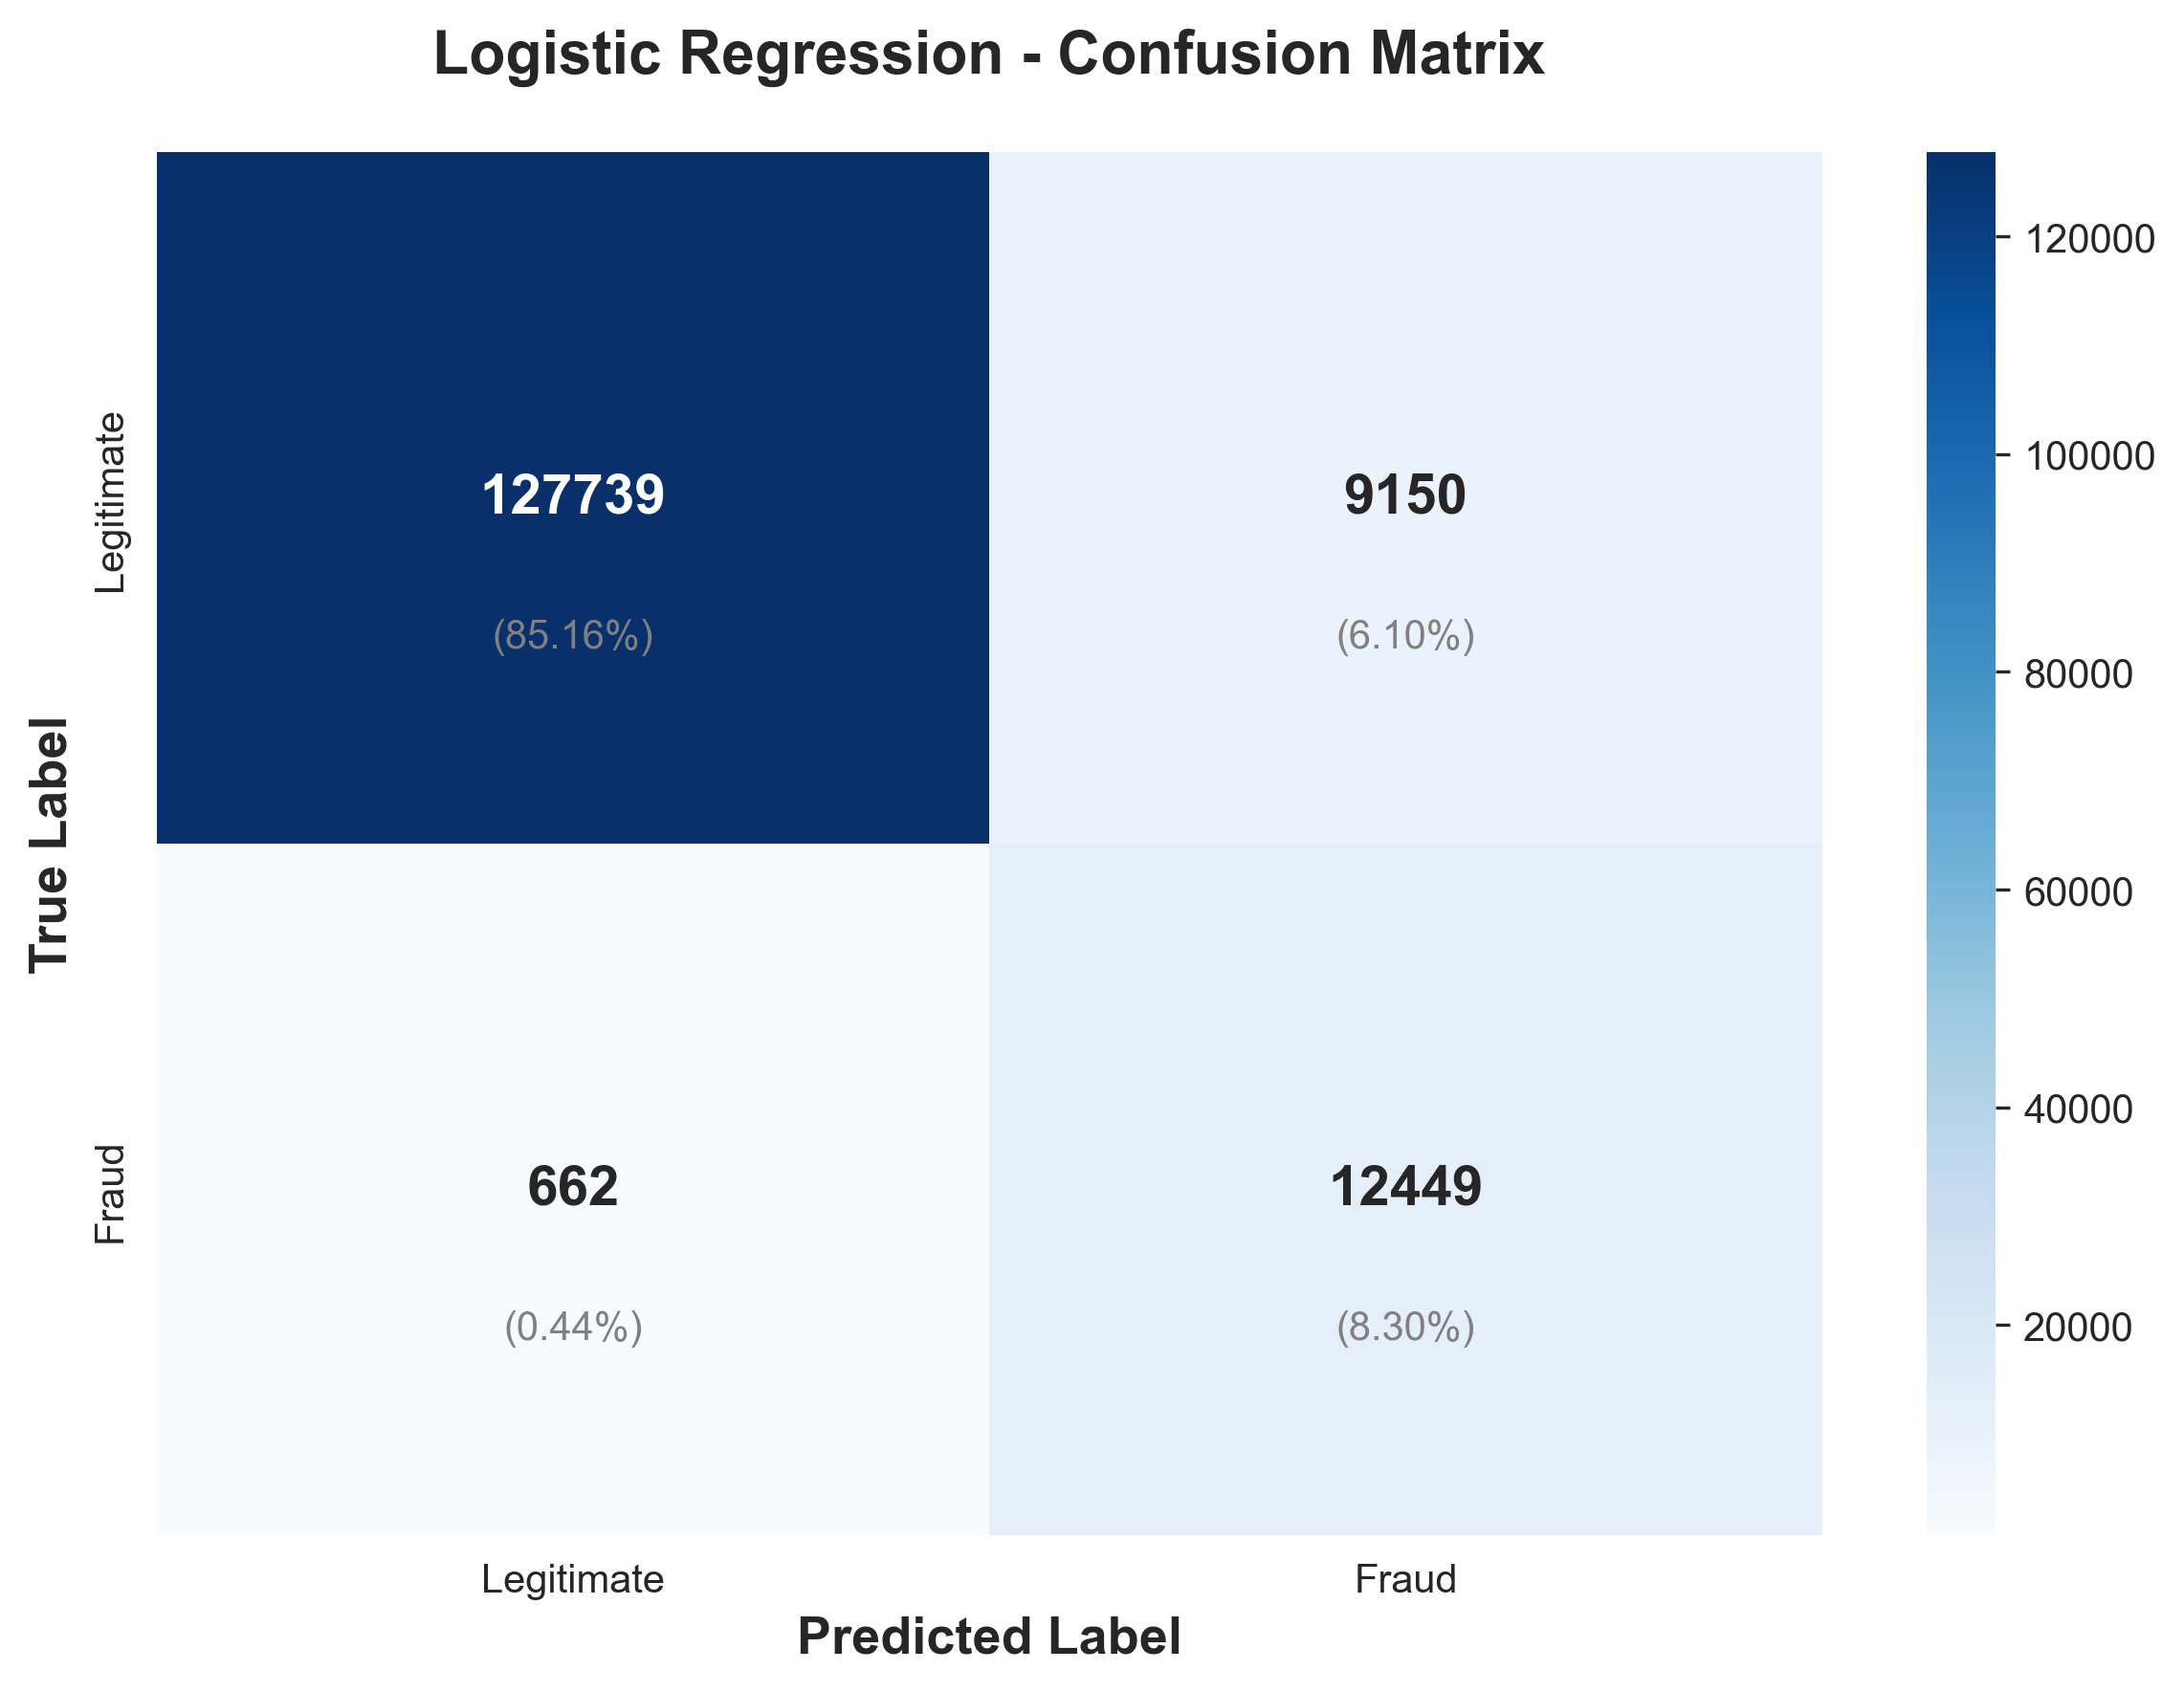

Confusion matrix saved to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\figures\rf_confusion_matrix.png


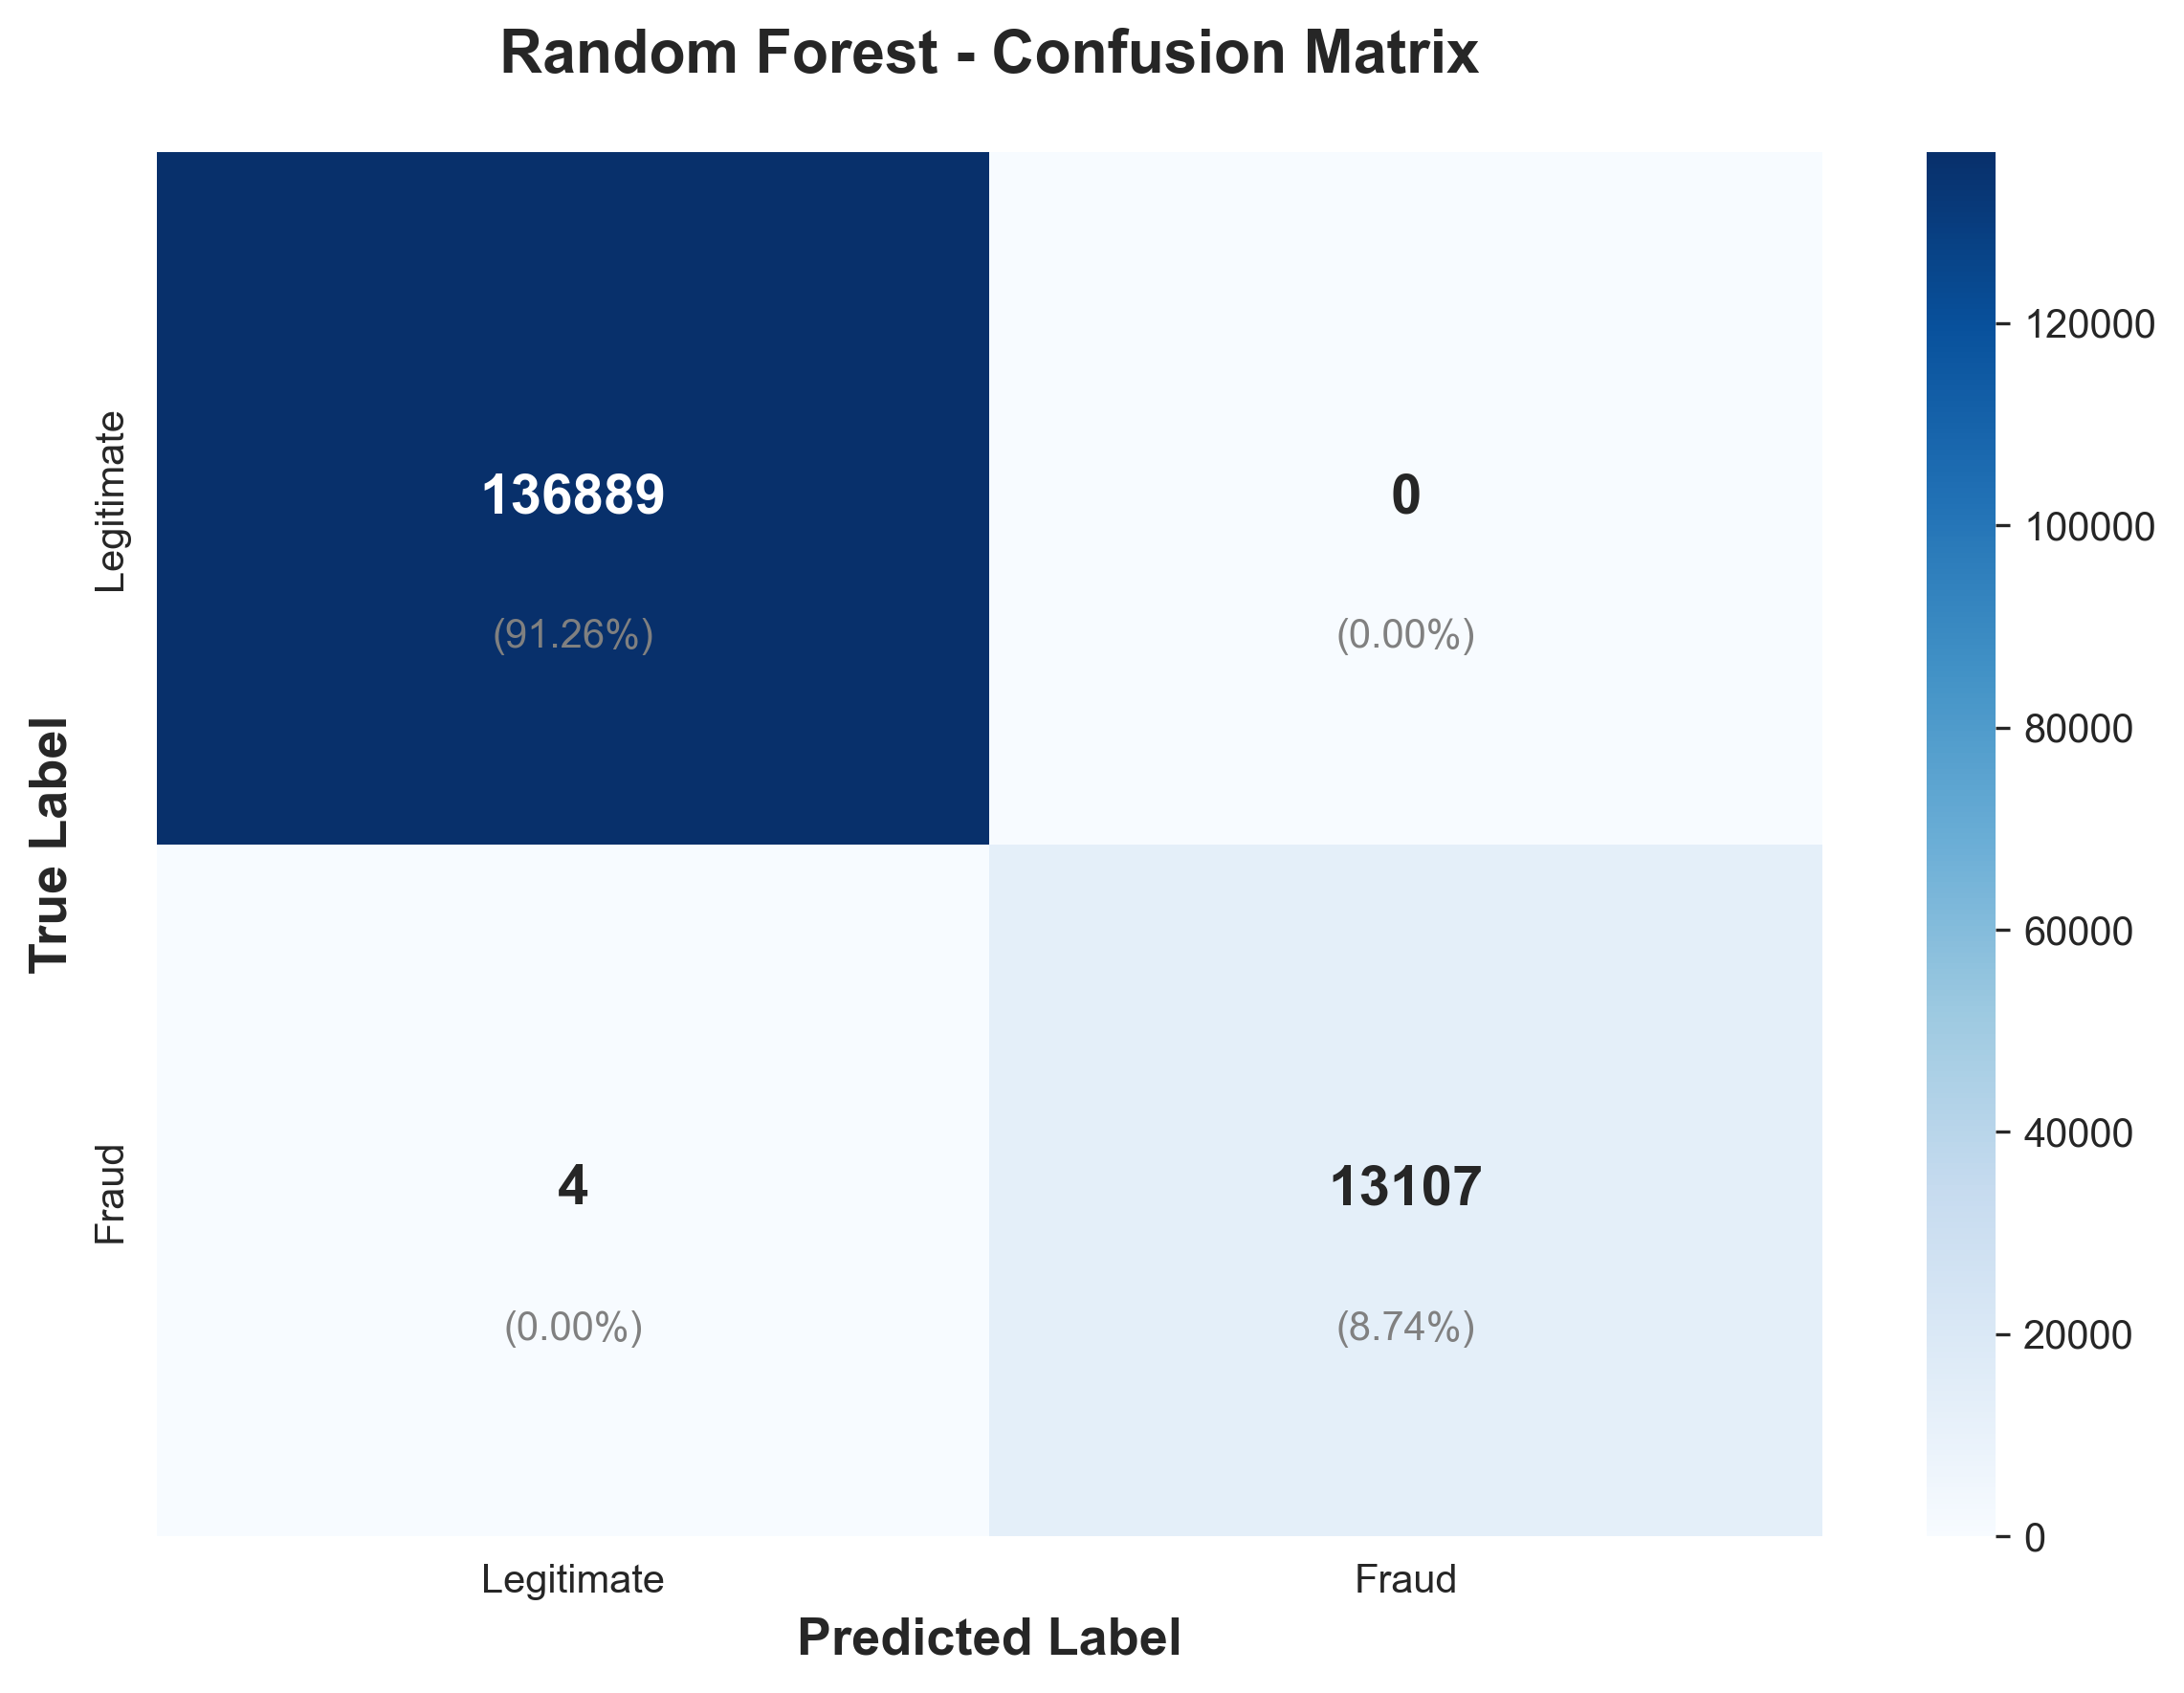

PR curve saved to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\figures\lr_pr_curve.png


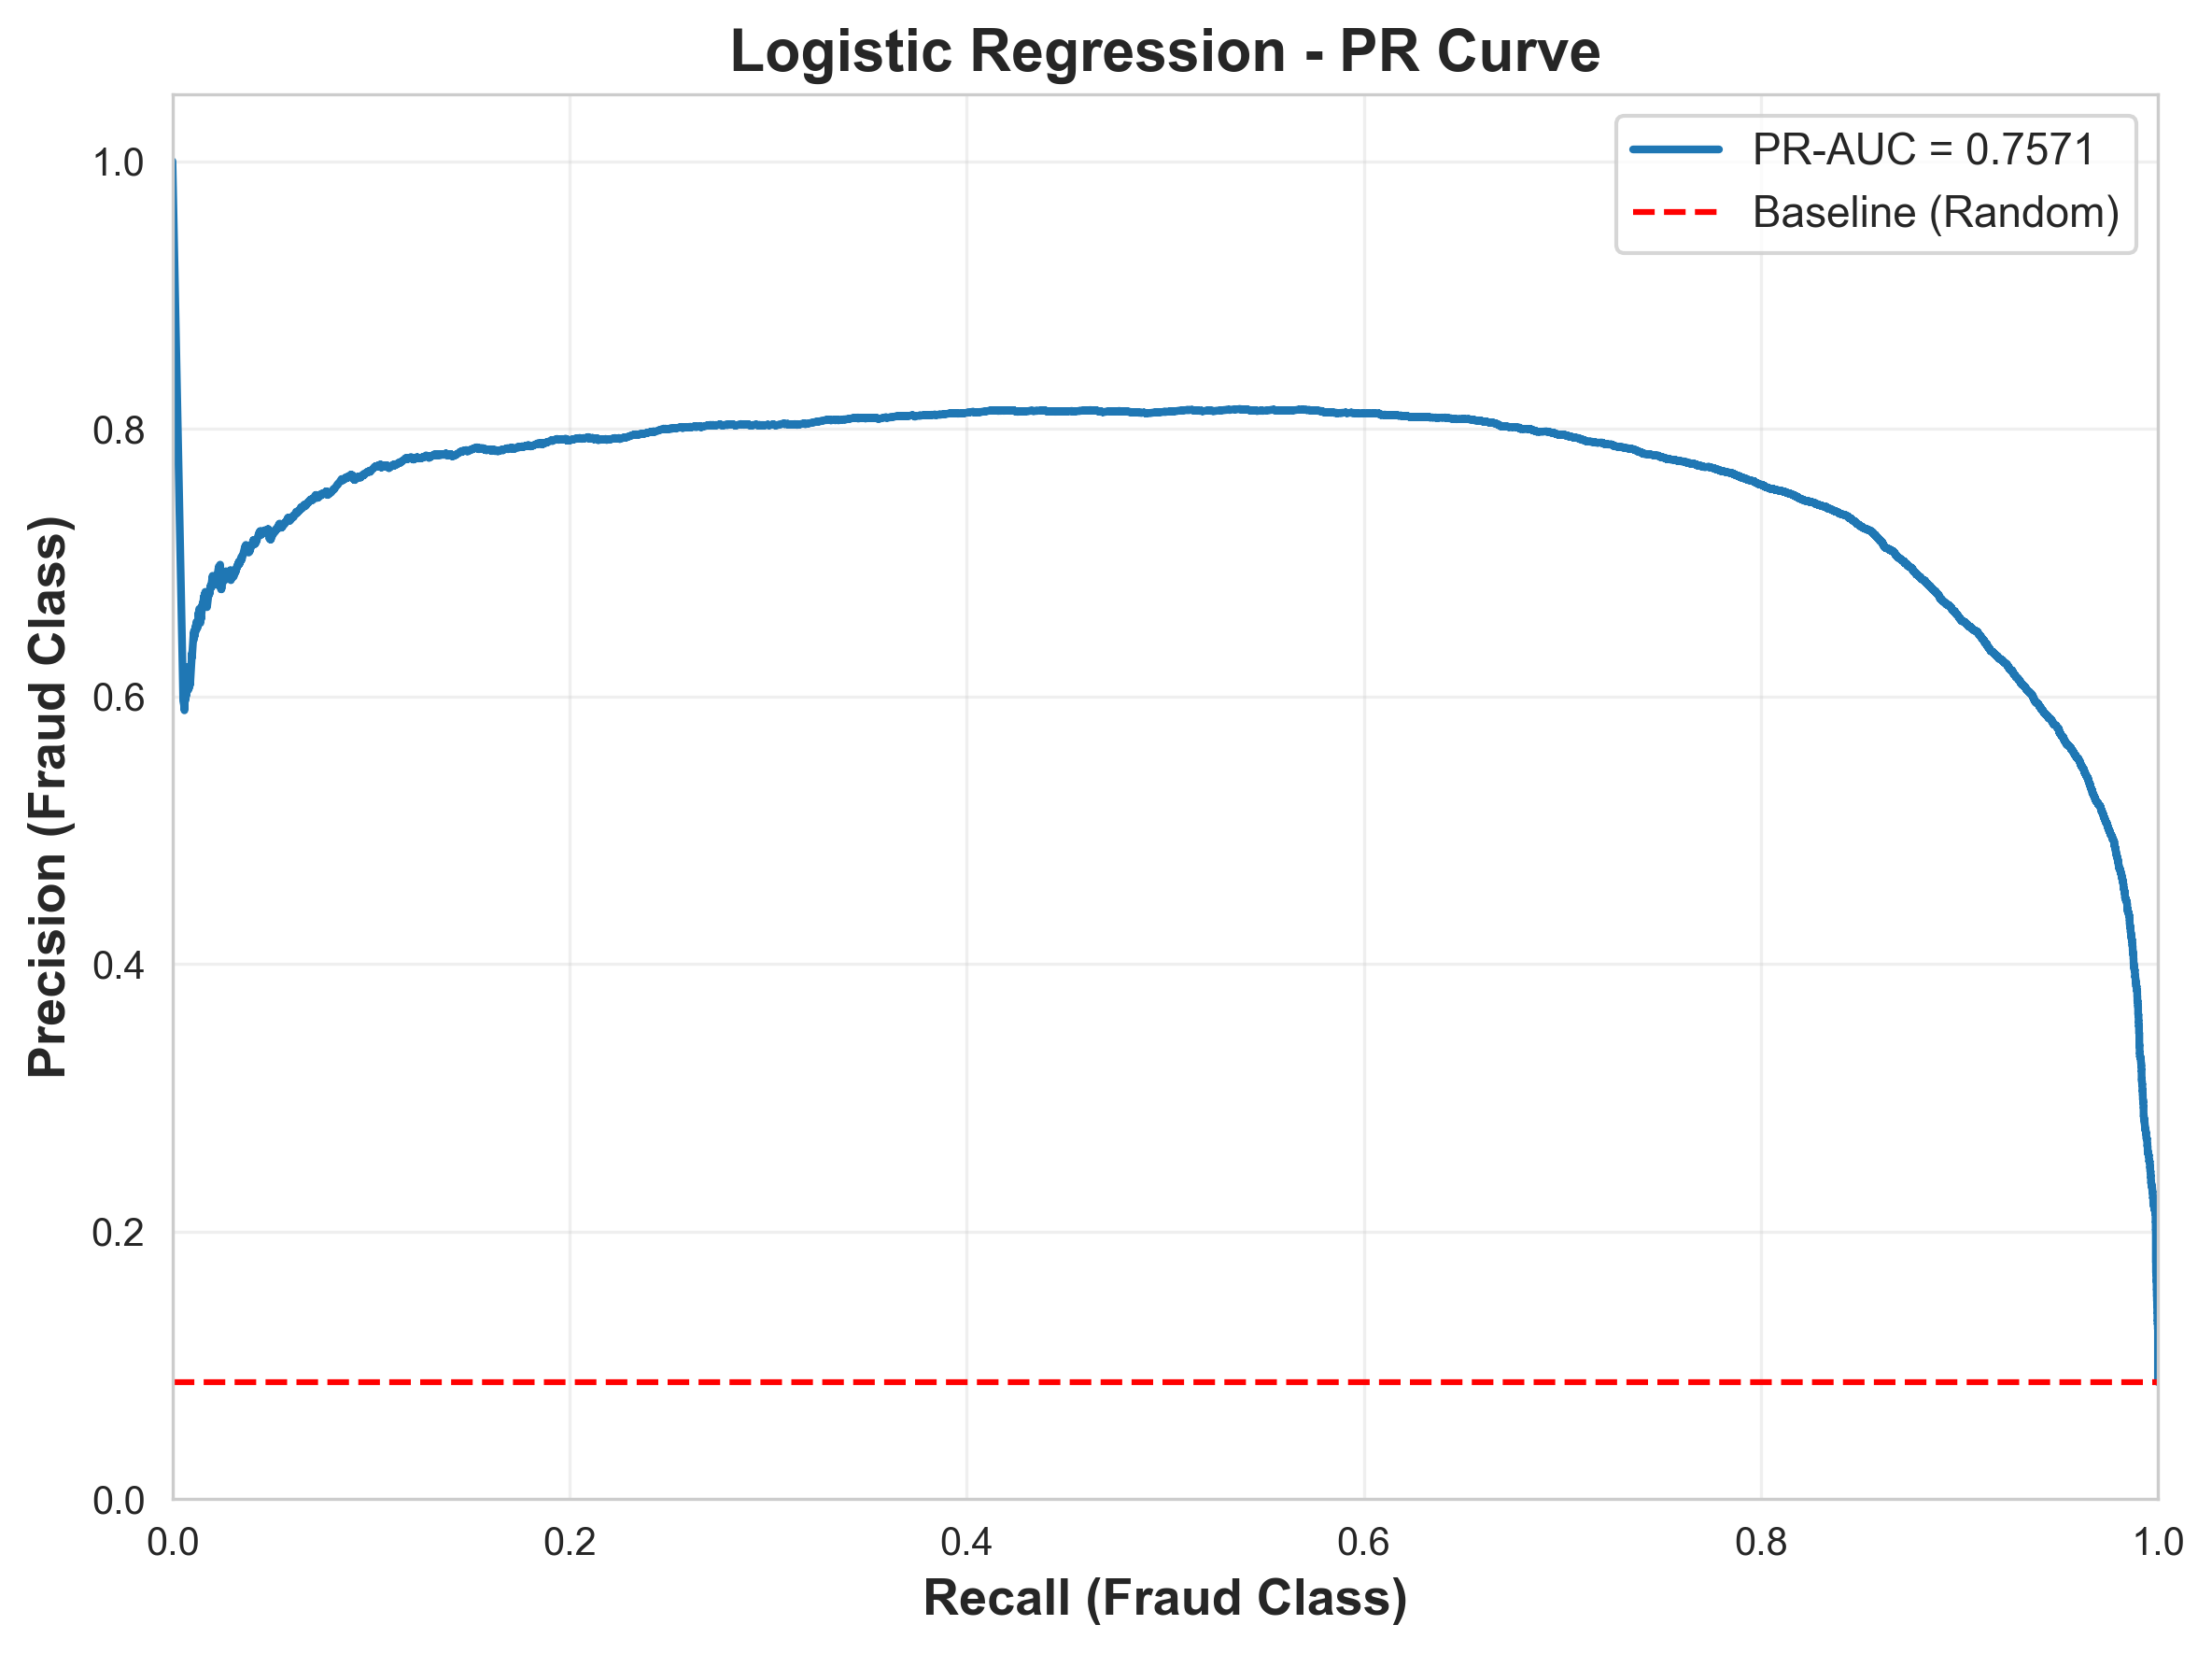

PR curve saved to c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\figures\rf_pr_curve.png


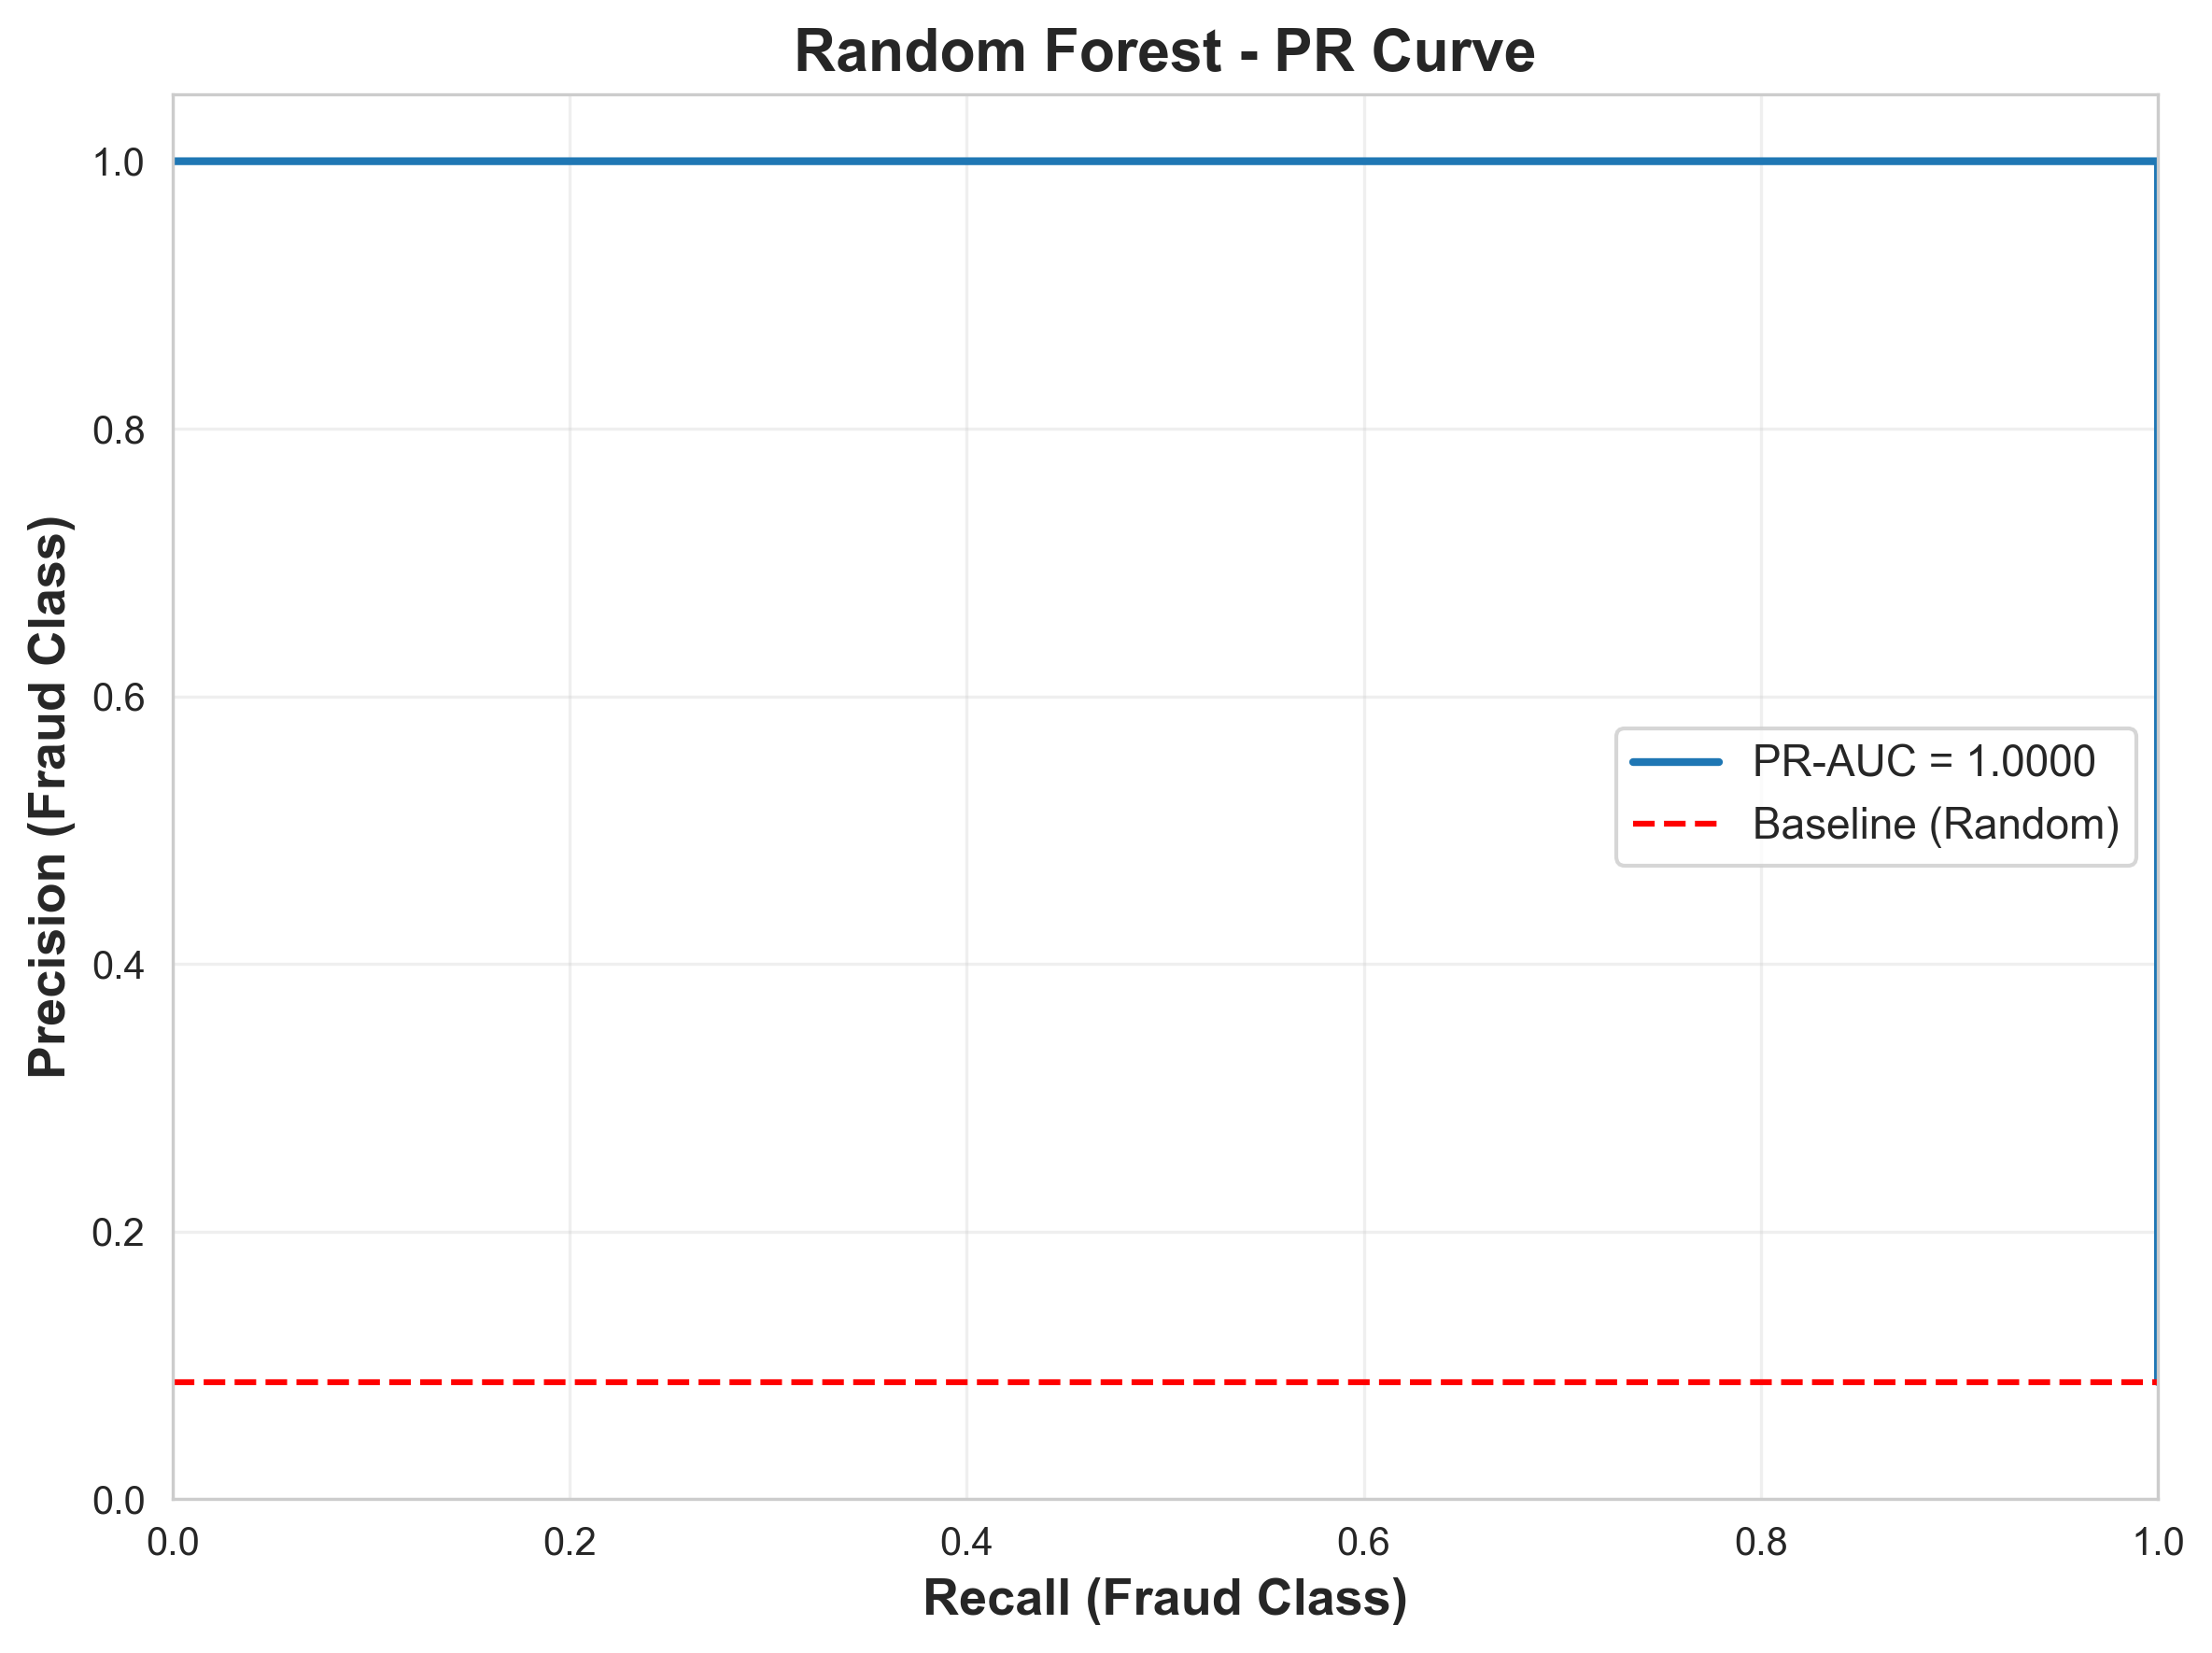


✓ All baseline visualizations saved to:
  c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\figures


In [7]:
# Visualize baseline comparisons
print("Generating baseline comparison visualizations...")

# Confusion matrices
plot_confusion_matrix(y_val, y_val_pred_lr, ['Legitimate', 'Fraud'], 
                     save_path=str(ds_config['figures_dir'] / 'lr_confusion_matrix.png'),
                     title='Logistic Regression - Confusion Matrix')

plot_confusion_matrix(y_val, y_val_pred_rf, ['Legitimate', 'Fraud'],
                     save_path=str(ds_config['figures_dir'] / 'rf_confusion_matrix.png'),
                     title='Random Forest - Confusion Matrix')

# PR curves
plot_precision_recall_curve(y_val, y_val_pred_proba_lr,
                            save_path=str(ds_config['figures_dir'] / 'lr_pr_curve.png'),
                            title='Logistic Regression - PR Curve')

plot_precision_recall_curve(y_val, y_val_pred_proba_rf,
                            save_path=str(ds_config['figures_dir'] / 'rf_pr_curve.png'),
                            title='Random Forest - PR Curve')

print("\n✓ All baseline visualizations saved to:")
print(f"  {ds_config['figures_dir']}")

## 7. Save Baseline Performance

In [8]:
# Create baseline summary DataFrame
baseline_results = pd.DataFrame({
    'model': ['Logistic Regression', 'Random Forest'],
    'pr_auc': [lr_metrics['pr_auc'], rf_metrics['pr_auc']],
    'roc_auc': [lr_metrics['roc_auc'], rf_metrics['roc_auc']],
    'f1_fraud': [lr_metrics['f1_fraud'], rf_metrics['f1_fraud']],
    'precision_fraud': [lr_metrics['precision_fraud'], rf_metrics['precision_fraud']],
    'recall_fraud': [lr_metrics['recall_fraud'], rf_metrics['recall_fraud']],
    'accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy']]
})

# Save to CSV
baseline_path = ds_config['tables_dir'] / 'baseline_results.csv'
baseline_results.to_csv(baseline_path, index=False)

print("✓ Baseline performance summary:")
print(baseline_results.to_string(index=False))
print(f"\n✓ Saved to: {baseline_path}")

✓ Baseline performance summary:
              model   pr_auc  roc_auc  f1_fraud  precision_fraud  recall_fraud  accuracy
Logistic Regression 0.757077  0.97972  0.717315         0.576369      0.949508  0.934587
      Random Forest 1.000000  1.00000  0.999847         1.000000      0.999695  0.999973

✓ Saved to: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\tables\baseline_results.csv


## 8. Summary & Next Steps

In [9]:
print("\n" + "="*70)
print(" NOTEBOOK 02 SUMMARY - card_transdata PREPROCESSING & BASELINES")
print("="*70)
print(f"✓ Dataset: card_transdata.csv (Synthetic)")
print(f"✓ Data split: {len(train_idx):,} train / {len(val_idx):,} val / {len(test_idx):,} test")
print(f"✓ Scaler fitted and saved")
print(f"✓ Split indices saved for reproducibility")
print("\n📊 Baseline Performance (Validation Set):")
print(f"  Logistic Regression:")
print(f"    - PR-AUC: {lr_metrics['pr_auc']:.4f}")
print(f"    - F1 (Fraud): {lr_metrics['f1_fraud']:.4f}")
print(f"  Random Forest:")
print(f"    - PR-AUC: {rf_metrics['pr_auc']:.4f}")
print(f"    - F1 (Fraud): {rf_metrics['f1_fraud']:.4f}")

print("\n🎯 Next Steps:")
print("  - Neural networks are NOT expected to beat RF on this synthetic dataset")
print("  - Value lies in: architecture exploration, ablation studies, design principles")
print("  - Best architecture will be transferred to creditcard.csv for validation")

print("\n📁 Artifacts Created:")
print(f"  - Split indices: {ds_config['results_dir']}/*.npy")
print(f"  - Fitted scaler: {ds_config['scaler_path']}")
print(f"  - Baseline models: {ds_config['models_dir']}/baselines/")
print(f"  - Baseline results: {baseline_path}")
print(f"  - Visualizations: {ds_config['figures_dir']}")

print("\n✅ Notebook 02 Complete!")
print("🚀 Ready for Notebook 03: card_transdata NN Architecture & Ablation")
print("="*70)


 NOTEBOOK 02 SUMMARY - card_transdata PREPROCESSING & BASELINES
✓ Dataset: card_transdata.csv (Synthetic)
✓ Data split: 700,000 train / 150,000 val / 150,000 test
✓ Scaler fitted and saved
✓ Split indices saved for reproducibility

📊 Baseline Performance (Validation Set):
  Logistic Regression:
    - PR-AUC: 0.7571
    - F1 (Fraud): 0.7173
  Random Forest:
    - PR-AUC: 1.0000
    - F1 (Fraud): 0.9998

🎯 Next Steps:
  - Neural networks are NOT expected to beat RF on this synthetic dataset
  - Value lies in: architecture exploration, ablation studies, design principles
  - Best architecture will be transferred to creditcard.csv for validation

📁 Artifacts Created:
  - Split indices: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata/*.npy
  - Fitted scaler: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\fitted_scaler.pkl
  - Baseline models: c:\Users\GOD\Documents\NNfinalProject\results\card_transdata\models/baselines/
  - Baseline results: c:\Users\GOD\Document